# Практическия реализация NLP

In this assignment you will perform sentiment analysis of the IMDBs reviews by using RNN.

In [1]:
# %%capture
!pip install torch==1.6.0
!pip install torchtext==0.7
!pip install numpy
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 748.8 MB 17 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cu113 requires torch==1.12.0, but you have torch 1.6.0 which is incompatible.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.6.0 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.6.0 which is incompatible.
fastai 2.7.6 requires torch<1.13,>=1.7, but you have torch 1.6.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████

In [2]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
np.random.seed(random_seed)

### Preparing Data

In [4]:
TEXT = Field(sequential=True, lower=True)
LABEL = LabelField()

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [5]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 9.89MB/s]
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [6]:
%%time
TEXT.build_vocab(trn)

CPU times: user 1.16 s, sys: 40.7 ms, total: 1.2 s
Wall time: 1.19 s


In [7]:
LABEL.build_vocab(trn)

In [8]:
TEXT.vocab.freqs.most_common(10)

[('the', 225693),
 ('a', 111990),
 ('and', 111448),
 ('of', 101112),
 ('to', 93691),
 ('is', 73340),
 ('in', 63498),
 ('i', 49202),
 ('this', 48843),
 ('that', 46403)]

### Creating the Iterator

During training, we'll be using a special kind of Iterator, the **BucketIterator**. 

All the neural networks require to have inputs of the same shape and size. So the data saples should be padded to the same length before gathering them into batches:

e.g.
\[ 
\[3, 15, 2, 7\],
\[4, 1\], 
\[5, 5, 6, 8, 1\] 
\] -> \[ 
\[3, 15, 2, 7, **0**\],
\[4, 1, **0**, **0**, **0**\], 
\[5, 5, 6, 8, 1\] 
\] 

If the sequences of one batch differ greatly in length, the padding will consume a lot of wasteful memory and time. The BucketIterator groups sequences of similar lengths together for each batch to minimize padding.

The **BucketIterator** usage:

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=True,
        sort_key=lambda x: len(x.text),
        sort_within_batch=False,
        device=device,
        repeat=False
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Let's take a look at the output of the BucketIterator

In [11]:
batch = next(train_iter.__iter__()); batch.text

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


tensor([[   10,  1314,  7971,  ...,  2658, 25305,     9],
        [   20,   141, 22357,  ...,  1167,     7,   378],
        [    7,  2306,     7,  ...,     3,     3,     2],
        ...,
        [    1,     1,     1,  ...,     3,    89,   220],
        [    1,     1,     1,  ...,     6,   139,   513],
        [    1,     1,     1,  ...,  4212,  6971,   112]], device='cuda:0')

In [12]:
batch.text.shape, batch.label.shape

(torch.Size([34, 64]), torch.Size([64]))

The batch contains all the fields we passed to the Dataset object that can be accessed as attributes with the corresponding names.

In [13]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])

### Define the RNN-based text classification model

Let's start with the simple architecture. Implement the model according to the scheme below.  
![alt text](https://miro.medium.com/max/1396/1*v-tLYQCsni550A-hznS0mw.jpeg)


In [14]:
class RNNBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim, v_size):
        super().__init__()
        self.emb = nn.Embedding(v_size, emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
            
    def forward(self, seq):
        embedded = self.emb(seq)
        h_seq, h_n = self.gru(embedded)
        preds = self.fc(h_n).squeeze()
        return preds

In [15]:
em_sz = 200
nh = 300
v_size = len(TEXT.vocab)
model = RNNBaseline(nh, em_sz, v_size)
model

RNNBaseline(
  (emb): Embedding(202243, 200)
  (gru): GRU(200, 300)
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

*If* you're using GPU, remember to call model.cuda() to move your model to the GPU.

In [16]:
model.to(device)

RNNBaseline(
  (emb): Embedding(202243, 200)
  (gru): GRU(200, 300)
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

### Training loop

Define the optimizer and the loss function

In [17]:
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.BCEWithLogitsLoss()

Set the number of training epochs

In [18]:
epochs = 7

Finally, run the training loop

In [19]:
%%time
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for cnt, batch in enumerate(train_iter): 
        x = batch.text
        y = batch.label.type(torch.float)  # Add float
        opt.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trn)
    
    val_loss = 0.0
    model.eval()
    for batch in val_iter:
        x = batch.text
        y = batch.label.type(torch.float)  # Add float
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item()

    val_loss /= len(vld)
    print(f'Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 1, Training Loss: 0.010021622337613787, Validation Loss: 0.008939041697978973
Epoch: 2, Training Loss: 0.0067315522074699406, Validation Loss: 0.006625395083427429
Epoch: 3, Training Loss: 0.0035556193845612664, Validation Loss: 0.008398453283309936
Epoch: 4, Training Loss: 0.0016661620554381184, Validation Loss: 0.00956684192419052
Epoch: 5, Training Loss: 0.0006988262528952743, Validation Loss: 0.01388237833182017
Epoch: 6, Training Loss: 0.0004248282752864595, Validation Loss: 0.010509449235598246
Epoch: 7, Training Loss: 0.00027971251561705556, Validation Loss: 0.012061216425895692
CPU times: user 1min 26s, sys: 2.11 s, total: 1min 28s
Wall time: 1min 32s


### Calculate performance of the trained model (10 points)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metric(model, tst=tst, test_iter=test_iter):
    y_true = np.zeros(len(tst))
    y_pred = np.zeros(len(tst))
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_iter):
            x = batch.text
            y = batch.label
            y_batch_pred = torch.exp(model(x))
            y_true[i * 64 : (i + 1) * 64] = y.cpu().numpy()
            y_pred[i * 64 : (i + 1) * 64] = y_batch_pred.cpu().numpy().flatten() > 0.5

    print(f'Accuracy: {accuracy_score(y_true, y_pred):.2f}')
    print(f'Precision: {precision_score(y_true, y_pred):.2f}')
    print(f'Recall: {recall_score(y_true, y_pred):.2f}')
    print(f'F1: {f1_score(y_true, y_pred):.2f}')

In [21]:
print_metric(model)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Accuracy: 0.81
Precision: 0.75
Recall: 0.91
F1: 0.82


In [22]:
# Accuracy: 0.81
# Precision: 0.75
# Recall: 0.91
# F1: 0.82

### Experiments

Feel free to experiment with the model to improve performance scores. You can find advices [here](https://arxiv.org/abs/1801.06146). 

Below describe, please, 
 - your improvements and challenges you faced
 - provide your experiments' implementation details
 - explain your choice of architecture/training method/regularization techniques etc.

## 1. Experiment (slanted triangular learning rates)

Попытка реализации из приведенной статьи метода stlr. Результат обучения модели получился, мягко говоря, слабый и все же я решил оставить свою попытку здесь.

Предположу что дело в примечании, которое я сразу не заметил "In other words, the number of epochs times the number of updates per epoch."

In [23]:
class STLR(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, last_epoch=-1, ratio=32, T=20, cut_frac=0.1, max_lr=0.001):
        self.ratio = ratio
        self.T = T
        self.cut_frac = cut_frac
        self.max_lr = max_lr
        super(STLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        self.cut = int(self.T * self.cut_frac)
        
        if self.last_epoch < self.cut:
            p = self.last_epoch / self.cut
        else:
            p = 1 - (self.last_epoch - self.cut) / (self.cut * (1 / self.cut_frac - 1))

        self.optimizer.param_groups[0]['lr'] = self.max_lr * (1 + p * (self.ratio - 1)) / self.ratio
        return [self.optimizer.param_groups[0]['lr']]

In [24]:
epochs = 10
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCEWithLogitsLoss()
stlr = STLR(optimizer=opt, last_epoch=-1, ratio=32, T=epochs, cut_frac=0.1, max_lr=0.01)

In [25]:
%%time
lr_value : list = []  # Add list lr
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for batch in train_iter: 
        x = batch.text
        y = batch.label.type(torch.float)  # Add float
        opt.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    lr_value.append(opt.param_groups[0]['lr'])  # Add counter lr
    stlr.step()  # STLR step
    epoch_loss = running_loss / len(trn)
    
    val_loss = 0.0
    model.eval()
    for batch in val_iter:
        x = batch.text
        y = batch.label.type(torch.float)  # Add float
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item()

    val_loss /= len(vld)
    print(f'Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 1, Training Loss: 4.755150257551577e-05, Validation Loss: 0.018475054144859313
Epoch: 2, Training Loss: nan, Validation Loss: nan
Epoch: 3, Training Loss: nan, Validation Loss: nan
Epoch: 4, Training Loss: nan, Validation Loss: nan
Epoch: 5, Training Loss: nan, Validation Loss: nan
Epoch: 6, Training Loss: nan, Validation Loss: nan
Epoch: 7, Training Loss: nan, Validation Loss: nan
Epoch: 8, Training Loss: nan, Validation Loss: nan
Epoch: 9, Training Loss: nan, Validation Loss: nan
Epoch: 10, Training Loss: nan, Validation Loss: nan
CPU times: user 2min 2s, sys: 2.74 s, total: 2min 4s
Wall time: 2min 5s


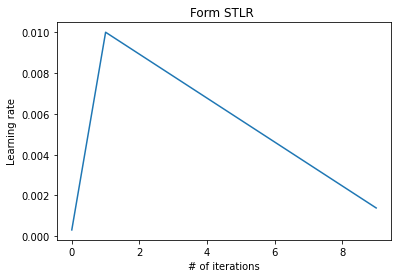

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(len(lr_value)), lr_value)
plt.title('Form STLR ' )
plt.xlabel('# of iterations')
plt.ylabel('Learning rate')
plt.show()

In [27]:
print_metric(model)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Accuracy: 0.50
Precision: 0.00
Recall: 0.00
F1: 0.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Accuracy: 0.50
# Precision: 0.00
# Recall: 0.00
# F1: 0.00

## 2. Experiment (3-layer LSTM)
В статье говорится
"The same 3-layer LSTM architecture—
with the same hyperparameters and no additions
other than tuned dropout hyperparameters—
outperforms highly engineered models and transfer learning approaches on six widely studied text
classification tasks."

Попробуем "прикрутить" 3 слоя LSTM вместо GRU и добавим Dropout 40% на каждый слой



In [28]:
class LSTM_RNNBaseline(nn.Module):
    """
    Helped me:
    https://towardsdatascience.com/implementation-differences-in-lstm-layers-tensorflow-vs-pytorch-77a31d742f74
    https://galhever.medium.com/sentiment-analysis-with-pytorch-part-4-lstm-bilstm-model-84447f6c4525
    """
    def __init__(self, hidden_dim, emb_dim, v_size):
        super().__init__()
        self.emb = nn.Embedding(v_size, emb_dim)
        self.lstm1 = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, dropout=0.4)
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, dropout=0.4)
        self.lstm3 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, dropout=0.4)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, seq):
        embedded = self.emb(seq)
        h1, (h1_T,c1_T) = self.lstm1(embedded)
        h2, (h2_T, c2_T) = self.lstm2(h1)
        h3, (h3_T, c3_T) = self.lstm3(h2)
        preds = self.fc(h3[-1,:,:])  # (L,N,D∗Hout) when batch_first=False
        
        return preds.squeeze()

In [29]:
em_sz = 200
nh = 300
v_size = len(TEXT.vocab)
model = LSTM_RNNBaseline(nh, em_sz, v_size)
model

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM_RNNBaseline(
  (emb): Embedding(202243, 200)
  (lstm1): LSTM(200, 300, dropout=0.4)
  (lstm2): LSTM(300, 300, dropout=0.4)
  (lstm3): LSTM(300, 300, dropout=0.4)
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [30]:
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.BCEWithLogitsLoss()
epochs = 7

In [31]:
%%time
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for cnt, batch in enumerate(train_iter): 
        x = batch.text
        y = batch.label.type(torch.float)
        opt.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trn)
    
    val_loss = 0.0
    model.eval()
    for batch in val_iter:
        x = batch.text
        y = batch.label.type(torch.float)
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item()

    val_loss /= len(vld)
    print(f'Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 1, Training Loss: 0.010192813185283115, Validation Loss: 0.011007394361495972
Epoch: 2, Training Loss: 0.010789148558889117, Validation Loss: 0.011008347916603088
Epoch: 3, Training Loss: 0.010822276765959604, Validation Loss: 0.01099231420358022
Epoch: 4, Training Loss: 0.010509782835415432, Validation Loss: 0.009640979878107707
Epoch: 5, Training Loss: 0.008033236139161246, Validation Loss: 0.008542178773880004
Epoch: 6, Training Loss: 0.004405189408149038, Validation Loss: 0.006967604927221934
Epoch: 7, Training Loss: 0.0019732903368771077, Validation Loss: 0.009090139547983805
CPU times: user 3min 30s, sys: 25.1 s, total: 3min 55s
Wall time: 3min 55s


In [32]:
print_metric(model)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Accuracy: 0.83
Precision: 0.88
Recall: 0.76
F1: 0.81


In [33]:
# Accuracy: 0.83
# Precision: 0.88
# Recall: 0.76
# F1: 0.81

## 3. Experiment (add BiLSTM)

В статье упоминаются Bidirectional language model

Посмотрим как поведет себя двунаправленная модель LSTM. За основу возьмем 3х слойную архитектуру использованную ранее.

In [45]:
class Bi_LSTM_RNNBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim, v_size):
        super().__init__()
        self.emb = nn.Embedding(v_size, emb_dim)
        self.lstm1 = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, bidirectional=True, dropout=0.4)
        self.lstm2 = nn.LSTM(input_size=hidden_dim * 2, hidden_size=hidden_dim, bidirectional=True, dropout=0.4)
        self.lstm3 = nn.LSTM(input_size=hidden_dim * 2, hidden_size=hidden_dim, bidirectional=True, dropout=0.4)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, seq):
        embedded = self.emb(seq)
        h1, (h1_T,c1_T) = self.lstm1(embedded)
        h2, (h2_T, c2_T) = self.lstm2(h1)
        h3, (h3_T, c3_T) = self.lstm3(h2)

        preds = self.fc(h3[-1,:,:])
        
        return preds.squeeze()

In [46]:
em_sz = 200
nh = 300
v_size = len(TEXT.vocab)
model = Bi_LSTM_RNNBaseline(nh, em_sz, v_size)
model

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Bi_LSTM_RNNBaseline(
  (emb): Embedding(202243, 200)
  (lstm1): LSTM(200, 300, dropout=0.4, bidirectional=True)
  (lstm2): LSTM(600, 300, dropout=0.4, bidirectional=True)
  (lstm3): LSTM(600, 300, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=600, out_features=1, bias=True)
)

In [47]:
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.BCEWithLogitsLoss()
epochs = 7

In [48]:
%%time
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for cnt, batch in enumerate(train_iter): 
        x = batch.text
        y = batch.label.type(torch.float)
        opt.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trn)
    
    val_loss = 0.0
    model.eval()
    for batch in val_iter:
        x = batch.text
        y = batch.label.type(torch.float)
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item()

    val_loss /= len(vld)
    print(f'Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 1, Training Loss: 0.01012602105140686, Validation Loss: 0.009876618282000224
Epoch: 2, Training Loss: 0.007506006842000144, Validation Loss: 0.007359970955053965
Epoch: 3, Training Loss: 0.004695729856831687, Validation Loss: 0.006657442762454351
Epoch: 4, Training Loss: 0.0029052818368588175, Validation Loss: 0.007377871958414713
Epoch: 5, Training Loss: 0.0018364197396274124, Validation Loss: 0.007418536039193471
Epoch: 6, Training Loss: 0.0012673374699162586, Validation Loss: 0.007652659524480502
Epoch: 7, Training Loss: 0.0005163283224018024, Validation Loss: 0.009892187837759654
CPU times: user 6min 58s, sys: 1min 20s, total: 8min 18s
Wall time: 8min 19s


In [49]:
print_metric(model)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Accuracy: 0.83
Precision: 0.89
Recall: 0.76
F1: 0.82


In [ ]:
# Accuracy: 0.83
# Precision: 0.89
# Recall: 0.76
# F1: 0.82

## 4. Experiment (add linear layer)

Добавим один полносвязный слой в конце.

Этот эксперимент показал лучший результат F1, и высокие результаты Recall и Precision, на тесте.

In [39]:
class Linear_RNNBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim, v_size):
        super().__init__()
        self.emb = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim,)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, seq):
        embedded = self.emb(seq)
        self.lstm.flatten_parameters()
        h, (h_T,c_T) = self.lstm(embedded)
        out = self.relu(self.fc1(h[-1,:,:]))
        preds = self.fc2(out)     
        return preds.squeeze()

In [40]:
em_sz = 200
nh = 300
v_size = len(TEXT.vocab)
model = Linear_RNNBaseline(nh, em_sz, v_size)
model

Linear_RNNBaseline(
  (emb): Embedding(202243, 200)
  (lstm): LSTM(200, 300)
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=300, out_features=1, bias=True)
)

In [41]:
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.BCEWithLogitsLoss()
epochs = 7

In [42]:
%%time
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for cnt, batch in enumerate(train_iter): 
        x = batch.text
        y = batch.label.type(torch.float)
        opt.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trn)
    
    val_loss = 0.0
    model.eval()
    for batch in val_iter:
        x = batch.text
        y = batch.label.type(torch.float)
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item()

    val_loss /= len(vld)
    print(f'Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 1, Training Loss: 0.010596711349487305, Validation Loss: 0.010025778738657634
Epoch: 2, Training Loss: 0.00858217374256679, Validation Loss: 0.010542406249046326
Epoch: 3, Training Loss: 0.006011102536746434, Validation Loss: 0.0062458453754583995
Epoch: 4, Training Loss: 0.002986657354448523, Validation Loss: 0.006183778937657674
Epoch: 5, Training Loss: 0.0014931640330169882, Validation Loss: 0.007623286259174347
Epoch: 6, Training Loss: 0.0005439712834211864, Validation Loss: 0.00921579901476701
Epoch: 7, Training Loss: 0.00018987881846925509, Validation Loss: 0.01112571081543962
CPU times: user 1min 37s, sys: 3.56 s, total: 1min 41s
Wall time: 1min 41s


In [43]:
print_metric(model)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Accuracy: 0.84
Precision: 0.85
Recall: 0.83
F1: 0.84


In [44]:
# Accuracy: 0.84
# Precision: 0.85
# Recall: 0.83
# F1: 0.84

Я объявил все возможные random.seed и все равно итоговые метрики изменяются в рамках одной сессии колаба. Буду рад если подскажете, в чем причина, где я ошибаюсь.